In [1]:
import os
import sys
import gc
import itertools

import torch
import scanpy as sc
import pandas as pd
import seaborn as sns
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import umap
from tqdm import tqdm
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
import torch.nn.functional as F
import anndata as ad
from scipy.sparse import csc_matrix
# expression_only1.data
# expression_only1.data.concatenate(expression_only2.data)
# expression=[expression_only1.data,expression_only2.data]
import scanpy as sc
# from context import unifan 
sys.path.append(r"../")
from unifan.datasets1 import AnnDataset, ContrDataset

from unifan.annoclusterV4 import AnnoCluster
from unifan.autoencoderV2 import autoencoder
from unifan.KLCLRv4 import KLCLR
from unifan.classifier import classifier
from unifan.utils import getGeneSetMatrix
from unifan.trainer import Trainer
from src.config_label import Config

/home/lcy/anaconda3/envs/unifan/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

config = Config()

In [20]:
adata1 = config.adata2

In [21]:
adata1

AnnData object with n_obs × n_vars = 5192 × 45947
    obs: 'nUMI', 'nGene', 'CellType_Category', 'Manuscript_Identity', 'Subclass_Cell_Identity', 'Disease_Identity', 'Subject_Identity', 'Library_Identity'
    var: 'HGNC_EnsemblAlt_GeneID', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [22]:
new_datatype_list = np.array(['aaaaaaaaaaaaaaaaa']*5192)

In [23]:

new_datatype_list[adata1.obs['Manuscript_Identity'] == 'B_Plasma'] = 'B_Plasma'
new_datatype_list[adata1.obs['Manuscript_Identity'] == 'B'] = 'B'
new_datatype_list[adata1.obs['Manuscript_Identity'] == 'T'] = 'T'
new_datatype_list[adata1.obs['Manuscript_Identity'] == 'NK'] = 'NK'
new_datatype_list[adata1.obs['Manuscript_Identity'] == 'Multiplet'] = 'Multiplet'
new_datatype_list[adata1.obs['CellType_Category'] == 'Myeloid'] = 'Myeloid'

In [24]:
adata1.obs['celltype'] = new_datatype_list

In [25]:
np.unique(adata1.obs['celltype'])
adata1.write('../../ipf_newcelltype_ipf.h5ad')

In [6]:
# clusters_true_project1 = np.load('../ipf_latest_control.npy')
# sex_mapping = {}
# k = 0
# for i in np.unique(clusters_true_project1):
#     sex_mapping[i] = k
#     k = k + 1
# clusters_true1 = clusters_true_project1
# print(clusters_true1)

# clusters_true_project2 = np.load('../ipf_latest_ipf.npy')
# sex_mapping = {}
# k = 0
# for i in np.unique(clusters_true_project2):
#     sex_mapping[i] = k
#     k = k + 1
# clusters_true2 = clusters_true_project2
# print(clusters_true2)

['T/NK/ILC' 'T/NK/ILC' 'T/NK/ILC' ... 'AT' 'AT' 'AT']
['T/NK/ILC' 'T/NK/ILC' 'T/NK/ILC' ... 'Ciliated' 'Ciliated' 'Ciliated']


In [5]:
config.adata1

AnnData object with n_obs × n_vars = 4807 × 45947
    obs: 'nUMI', 'nGene', 'CellType_Category', 'Manuscript_Identity', 'Subclass_Cell_Identity', 'Disease_Identity', 'Subject_Identity', 'Library_Identity'
    var: 'HGNC_EnsemblAlt_GeneID', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [3]:
clusters_true_project1 = config.adata1.obs['Manuscript_Identity']
sex_mapping = {}
k = 0
for i in np.unique(clusters_true_project1):
    sex_mapping[i] = k
    k = k + 1
clusters_true1 = clusters_true_project1
print(clusters_true1)

clusters_true_project2 = config.adata2.obs['Manuscript_Identity']
sex_mapping = {}
k = 0
for i in np.unique(clusters_true_project2):
    sex_mapping[i] = k
    k = k + 1
clusters_true2 = clusters_true_project2
print(clusters_true2)

CellBarcode_Identity
001C_AAAGTAGCAATGACCT          Basal
001C_AACCGCGGTTATGTGC          Basal
001C_ACACCCTCATTGTGCA           ATII
001C_ACAGCCGGTGTTGGGA            ATI
001C_ACCGTAATCACTTCAT          Basal
                            ...     
484C_CTGTTTAGTCACCCAG    Mesothelial
484C_GAGTCCGGTAAGGGCT           Club
484C_GGACAAGCAAGCGCTC       Ciliated
484C_GTTACAGCATGTAAGA          Basal
484C_TCAATCTAGGTGATAT           ATII
Name: Manuscript_Identity, Length: 4807, dtype: category
Categories (9, object): ['ATI', 'ATII', 'Basal', 'Ciliated', ..., 'Goblet', 'Ionocyte', 'Mesothelial', 'PNEC']
CellBarcode_Identity
010I_AAACCTGAGCTTTGGT    Ciliated
010I_AAACCTGAGTTGAGTA    Ciliated
010I_AAACCTGCATGGTAGG        Club
010I_AAACCTGGTAGGACAC      Goblet
010I_AAAGATGGTCATGCAT        Club
                           ...   
59I_TGGCCAGTCGTACGGC        Basal
59I_TGTATTCTCAGTCAGT     Ciliated
59I_TGTGTTTTCAGGATCT     Ciliated
59I_TTCCCAGTCCTGCCAT         ATII
59I_TTGACTTTCCAGATCA     Ciliated
Name: Man

In [4]:

model_autoencoder = autoencoder(input_dim=config.G, z_dim=config.z_dim, 
                                encoder_dim=config.z_encoder_dim, emission_dim=config.z_decoder_dim,
                                num_layers_encoder=config.z_encoder_layers, num_layers_decoder=config.z_decoder_layers,
                                reconstruction_network='gaussian', decoding_network='gaussian',
                                use_cuda=config.use_cuda)

In [5]:
trainer = Trainer(dataset = config.expression_integrated, model=model_autoencoder,learning_rate=0.001, model_name="pretrain_z_ZINB", batch_size=1024,
                            num_epochs=config.pretrain_epoch, save_infer=True, output_folder=config.pretrain_z_folder, num_workers=0,
                            use_cuda=config.use_cuda)
trainer.train()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.41it/s]



loss = 0.2264062771025826
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.54it/s]



loss = 0.15352855622768402
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.70it/s]



loss = 0.14784269385478077
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.73it/s]



loss = 0.1452101504101473
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.73it/s]



loss = 0.14341987406506257
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.73it/s]



loss = 0.14245861681068644
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.64it/s]



loss = 0.14183586660553427
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.66it/s]



loss = 0.13978134358630462
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.59it/s]



loss = 0.13643348392318277
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.67it/s]



loss = 0.13449457813711727
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.68it/s]



loss = 0.13355385555940516
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.71it/s]



loss = 0.13306643463232937
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.72it/s]



loss = 0.1325969108763863
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.56it/s]



loss = 0.13236826219979456
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.67it/s]



loss = 0.13215109530617208
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.71it/s]



loss = 0.13201050022069147
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]



loss = 0.13198427198564305
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.62it/s]



loss = 0.13176023960113525
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.68it/s]



loss = 0.1315705846337711
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.65it/s]



loss = 0.1314036215052885
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.72it/s]



loss = 0.13122662069166408
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]



loss = 0.13106465339660645
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]



loss = 0.13090245075085583
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.54it/s]



loss = 0.13076122762525783
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.69it/s]



loss = 0.1306394496384789
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.71it/s]



loss = 0.13049480012234518
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.66it/s]



loss = 0.1304466483347556
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.59it/s]



loss = 0.13028481515014873
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.60it/s]



loss = 0.1301487636040239
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.62it/s]



loss = 0.13003030375522726
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.60it/s]



loss = 0.1298431035350351
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.64it/s]



loss = 0.12967067825443604
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.62it/s]



loss = 0.12961604051730213
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.60it/s]



loss = 0.1287976406952914
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.67it/s]



loss = 0.12830207891323986
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.66it/s]



loss = 0.12809757274739883
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.72it/s]



loss = 0.12791915150249705
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.68it/s]



loss = 0.12771912927136703
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.67it/s]



loss = 0.12761415847960642
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.69it/s]



loss = 0.12748116035671794
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.48it/s]


In [6]:
z_init = np.load(config.input_z_ZINB_path)
try:
    z_init = z_init.numpy()
except AttributeError:
    pass
z_init1 = z_init[:config.N_project1]
z_init2 = z_init[config.N_project1:]

In [9]:
z_init1 = z_init2
clusters_true1 = clusters_true2

In [13]:
z_dim = 128
random_seed=22
# initialize using leiden clustering
adata = sc.AnnData(X=z_init1)
adata.obsm['X_unifan'] = z_init1
sc.pp.neighbors(adata, n_pcs=z_dim,  use_rep='X_unifan', random_state=random_seed)



best_ari = 0
best_resolution = 0
for resolution in range (1,100):
    resolution = resolution / 100
    sc.tl.leiden(adata, resolution=resolution, random_state=random_seed)
    clusters_pre1 = adata.obs['leiden'].astype('int').values
    ari_smaller = adjusted_rand_score(clusters_true1,
                                      clusters_pre1)
    if ari_smaller>best_ari:
        best_ari = ari_smaller
        best_resolution = resolution


sc.tl.leiden(adata, resolution=1, random_state=random_seed)
clusters_pre1 = adata.obs['leiden'].astype('int').values  # original as string



# initialize centroids
try:
    df_cluster = pd.DataFrame(z_init1.detach().cpu().numpy())
except AttributeError:
    df_cluster = pd.DataFrame(z_init1)

cluster_labels = np.unique(clusters_pre1)
M = len(set(cluster_labels))  # set as number of clusters
df_cluster['cluster'] = clusters_pre1

# get centroids
centroids = df_cluster.groupby('cluster').mean().values
centroids_torch_project1 = torch.from_numpy(centroids)
print(centroids_torch_project1.shape)

torch.Size([26, 128])


Z: ARI for smaller cluster: 0.11552979266815765
Z: NMI for smaller cluster: 0.4564156844281767
Z: silhouette for smaller cluster: 0.191064715385437


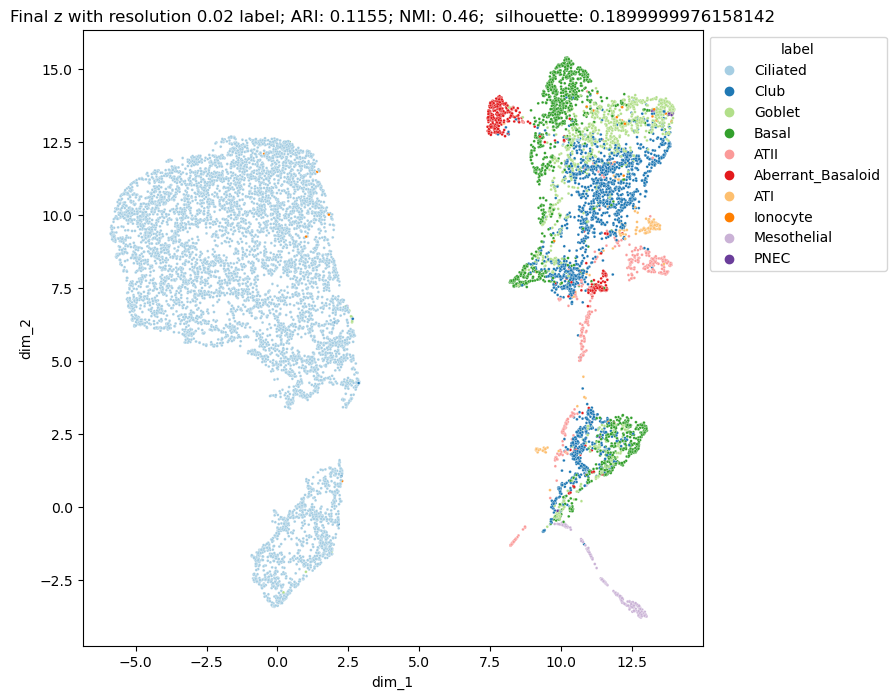

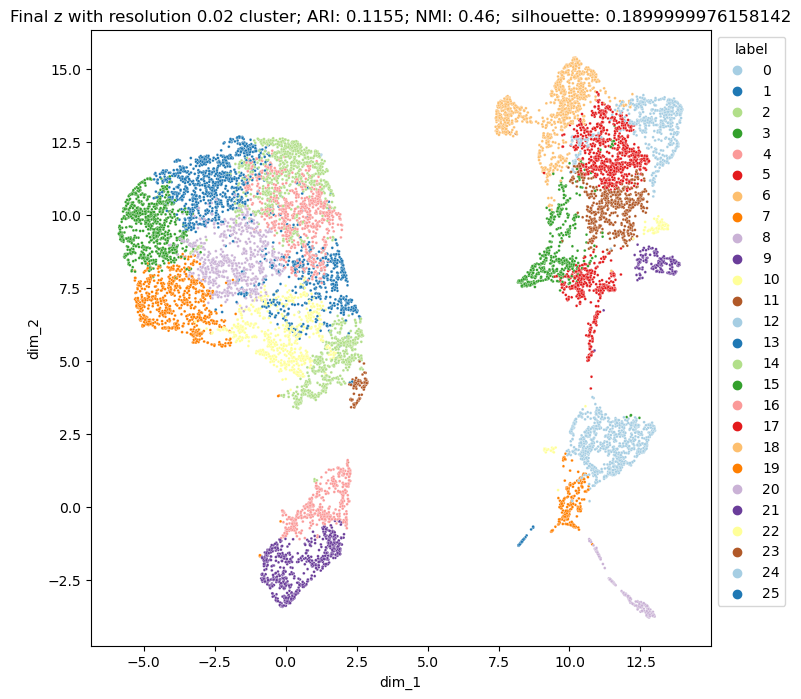

In [14]:

if clusters_true1 is not None:

    ari_smaller = adjusted_rand_score(clusters_true1,
                                      clusters_pre1)
    nmi_smaller = adjusted_mutual_info_score(clusters_true1, clusters_pre1)
    silhouette = silhouette_score(z_init1, clusters_pre1)
    print(f"Z: ARI for smaller cluster: {ari_smaller}")
    print(f"Z: NMI for smaller cluster: {nmi_smaller}")
    print(f"Z: silhouette for smaller cluster: {silhouette}")
else:
    ari_smaller = np.nan
    nmi_smaller = np.nan

umap_original = umap.UMAP(metric='correlation').fit_transform(z_init1)

# color by cluster
hues = {'label': clusters_true_project2.tolist(), 'cluster': clusters_pre1}
for k, v in hues.items():
    df_plot = pd.DataFrame(umap_original)
    if v is None:
        df_plot['label'] = np.repeat("Label not available", df_plot.shape[0])
    else:
        df_plot['label'] = v
    df_plot['label'].astype('str')
    df_plot.columns = ['dim_1', 'dim_2', 'label']

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(x='dim_1', y='dim_2', hue='label', data=df_plot, palette="Paired",
                    legend=True, s=4)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title(f"Final z with resolution {best_resolution} {k}; ARI: {round(ari_smaller, 4)}; NMI: {round(nmi_smaller, 2)};  silhouette: {round(silhouette, 2)}")
#     plt.savefig(os.path.join(pretrain_z_folder, f"z_{z_epoch}_{k}.png"), bbox_inches="tight", format="png")
    #plt.savefig(k+'ipf_control_scICA.pdf',bbox_inches = 'tight')
    plt.show()
    
    plt.close()